In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

root_dir = "Compare_with_SciANN"

results_df = pd.DataFrame(columns=[
    'Tag', 'Noise', 'Numx', 'Time_limit', 'Differentiation Type', 'MSE', 'Coefficients', 'Lambda'
])

noise_level = 0.005


for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    
    # Only process directories and filter by noise level
    if os.path.isdir(folder_path) and f'_{noise_level}_' in folder:
        parts = folder.split('_')
        tag = parts[1]
        noise = parts[2]
        numx = parts[4]
        time_limit = parts[6]
        differentiation_type = parts[3]
        # print(tag, noise, numx, time_limit, differentiation_type)

        # Look for both `metrics` and `coefs` CSV files within the subfolder
        metrics_files = [f for f in os.listdir(folder_path) if f.startswith('metrics') and f.endswith('.csv')]
        coefs_files = [f for f in os.listdir(folder_path) if f.startswith('coefs') and f.endswith('.csv')]
        threshold_files = [f for f in os.listdir(folder_path) if f.startswith('threshold') and f.endswith('.csv')]

        # read the metricfile and coefs file 
        metrics_df = pd.read_csv(os.path.join(folder_path, metrics_files[0]))
        coefs_df = pd.read_csv(os.path.join(folder_path, coefs_files[0]))
        threshold_df = pd.read_csv(os.path.join(folder_path, threshold_files[0]))
        # Metric      Test
        # 0    MSE  0.004776
        # 1    MAE  0.027688
        #    alpha_1       alpha_2   alpha_3   alpha_4       alpha_5        beta_1  \
        # 0     0.36  6.415562e-16 -0.251006 -0.132956 -4.194034e-16 -4.831885e-17  
        mse_value = metrics_df[metrics_df['Metric'] == 'MSE']['Test'].values[0]
        coefs_df = coefs_df.round(4)
        
        coefs_dict = coefs_df.iloc[0].to_dict()
        new_row = {
            'Tag': tag,
            'Noise': noise,
            'Numx': numx,
            'Time_limit': time_limit,
            'Differentiation Type': differentiation_type,
            'MSE': mse_value,
            'Coefficients': coefs_dict,
            'Lambda': threshold_df['Threshold'].values[0]
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

results_df.to_csv(f'{root_dir}/results.csv', index=False)

# choose the best model based on the MSE for 3 different cases by Tag SG, Coex and Surv for 3 different time_limit [0,10], [10, 24], [0,24] total 9 moedls
best_models = results_df.groupby(['Tag', 'Time_limit']).apply(lambda x: x.loc[x['MSE'].idxmin()]).reset_index(drop=True)
best_models.to_csv(f'{root_dir}/best_models.csv', index=False)
best_models.head(9) 

C:\Users\tirth\AppData\Local\Temp\ipykernel_13656\3071695259.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


,Tag,Noise,Numx,Time_limit,Differentiation Type,MSE,Coefficients,Lambda
0,Coex,0.005,100,"[0, 10]",SFD,0.005934,"{'alpha_1': 1.1, 'alpha_2': -0.0, 'alpha_3': -...",0.55
1,Coex,0.005,100,"[0, 24]",SFD,0.002775,"{'alpha_1': 0.94, 'alpha_2': 0.0, 'alpha_3': -...",0.47
2,Coex,0.005,100,"[10, 24]",FD,0.007231,"{'alpha_1': 0.78, 'alpha_2': 0.0, 'alpha_3': -...",0.39
3,SG,0.005,100,"[0, 10]",FD,0.000099,"{'alpha_1': 0.9781, 'alpha_2': -0.97}",0.03
4,SG,0.005,100,"[0, 24]",SFD,0.000014,"{'alpha_1': 0.9908, 'alpha_2': -0.99}",0.01
5,SG,0.005,100,"[10, 24]",FD,0.000020,"{'alpha_1': 0.9957, 'alpha_2': -1.0}",0.00
6,Surv,0.005,100,"[0, 10]",FD,0.002193,"{'alpha_1': 0.8, 'alpha_2': -0.0, 'alpha_3': -...",0.40
7,Surv,0.005,100,"[0, 24]",FD,0.000427,"{'alpha_1': 0.82, 'alpha_2': 0.0, 'alpha_3': -...",0.41
8,Surv,0.005,100,"[10, 24]",SFD,0.088729,"{'alpha_1': 0.74, 'alpha_2': -0.0, 'alpha_3': ...",0.37


Coexistence:
$$u' = 1 \cdot u + 0 \cdot v + (-0.7) \cdot u^2 + (-0.3) \cdot uv + 0 \cdot v^2 $$
$$v' =  0 \cdot u + 0.5 \cdot v + 0 \cdot u^2 + (-0.15) \cdot uv + (-0.3) \cdot v^2 $$
Survival:
$$u' = 1 \cdot u + 0 \cdot v + (-0.3) \cdot u^2 + (-0.6) \cdot uv + 0 \cdot v^2 $$
$$v' =  0 \cdot u + 0.5 \cdot v + 0 \cdot u^2 + (-0.35) \cdot uv + (-0.15) \cdot v^2 $$

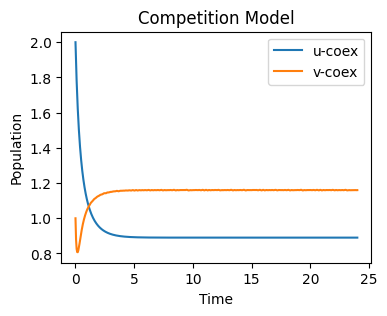

In [2]:
def CompetitionModelExpanded(t, q, params): 
    # True model a1 = 1, a2 = 0, a3 = -a_1, a4 = -a2, a5 = 0, 
                # b1 = 0, b2 = r, b3 = 0, b4 = -rb_1, b5 = -rb_2
    u, v = q
    a1, a2, a3, a4, a5, b1, b2, b3, b4, b5 = params
    du_dt = a1*u + a2*v + a3*u**2 + a4*u*v + a5*v**2
    dv_dt = b1*u + b2*v + b3*u**2 + b4*u*v + b5*v**2
    return [du_dt, dv_dt]

def SaturatedGrowthModelExpanded(t,q, params):
    # True model: a1 = 1, a2 = -1
    a1, a2 = params
    u = q
    return a1*u + a2*u**2

def plot_single_model_from_params(params, model, initial_conditions, 
                                  tbegin=0, tend=24, nTest=500, ax=None, 
                                  title=None, tag=None, u_linestyle='-', v_linestyle='-',
                                  u_color=None, v_color=None):

    t_span = (tbegin, tend)
    t_eval = np.linspace(tbegin, tend, nTest)
    sol = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t_eval)
    t = sol.t
    u_sol = sol.y[0].T
    if model == CompetitionModelExpanded:
        v_sol = sol.y[1].T
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(t, u_sol, label=f'u-{tag}', linestyle=u_linestyle, color=u_color or None)
    if model == CompetitionModelExpanded:
        ax.plot(t, v_sol, label=f'v-{tag}', linestyle=v_linestyle, color=v_color or None)
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Model')
    ax.legend()
    if ax is None:
        plt.show()

# Test
params = best_models.loc[0]['Coefficients'].values()
comp_model_ic = [2,1]
sg_model_ic = [0.01]
plot_single_model_from_params(params, CompetitionModelExpanded, comp_model_ic, title='Competition Model', tag="coex")
    


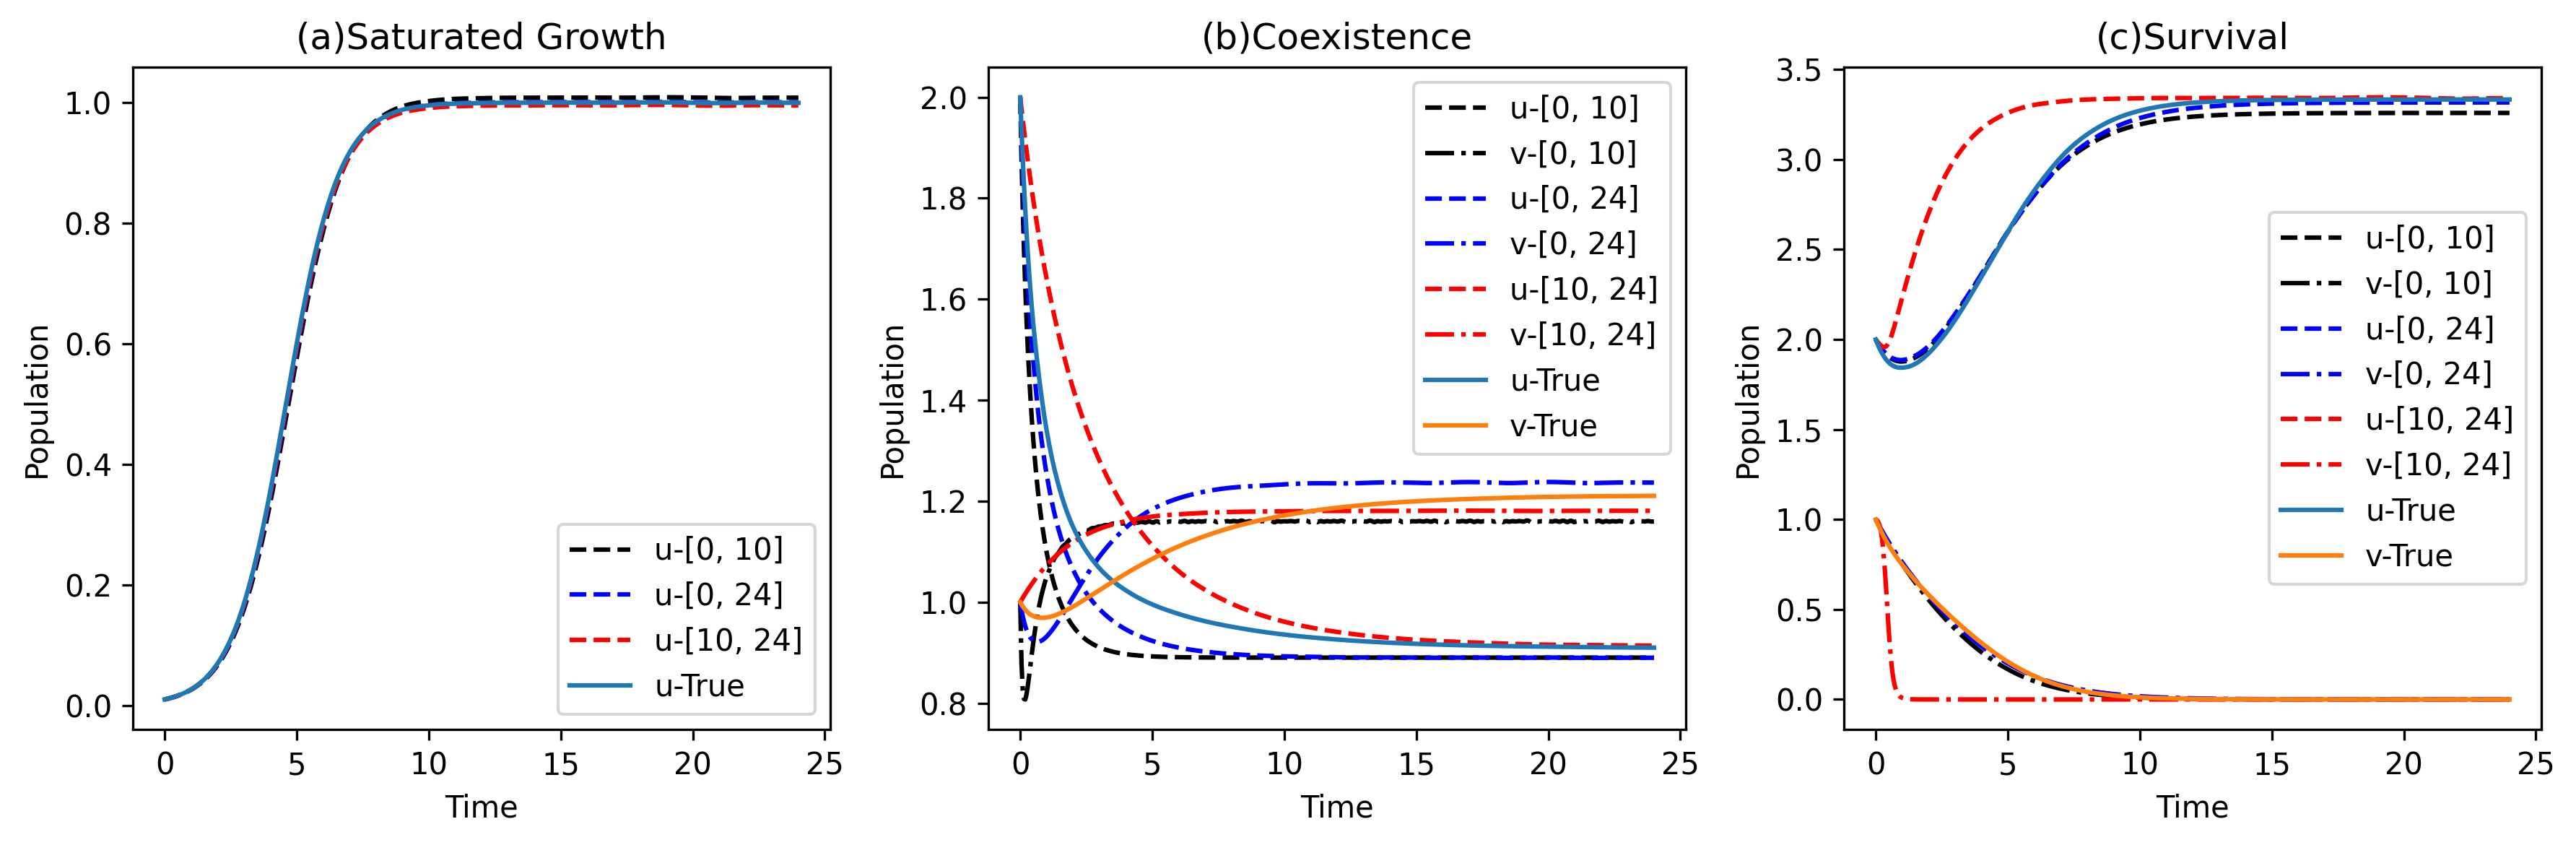

In [3]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
time_labels = ["[0, 10]", "[10, 24]", "[0, 24]"]
colors = ['black', 'red', 'blue']
# loop through each row 
for index, row in best_models.iterrows():
    params = row['Coefficients'].values()
    initial_conditions = [2,1] if row['Tag'] in ['Coex', 'Surv'] else [0.01]
    time_tag = row['Time_limit']

    if row['Tag'] == 'SG':
        plot_single_model_from_params(params, SaturatedGrowthModelExpanded, initial_conditions, ax=axs[0], tag=time_tag,
                                      u_linestyle='--', v_linestyle='-.', 
                                      u_color=colors[time_labels.index(time_tag)], v_color=colors[time_labels.index(time_tag)])
    elif row['Tag'] == 'Coex':
        plot_single_model_from_params(params, CompetitionModelExpanded, initial_conditions, ax=axs[1], tag=time_tag,
                                      u_linestyle='--', v_linestyle='-.', 
                                      u_color=colors[time_labels.index(time_tag)], v_color=colors[time_labels.index(time_tag)])
    elif row['Tag'] == 'Surv':
        plot_single_model_from_params(params, CompetitionModelExpanded, initial_conditions, ax=axs[2], tag=time_tag,
                                      u_linestyle='--', v_linestyle='-.', 
                                      u_color=colors[time_labels.index(time_tag)], v_color=colors[time_labels.index(time_tag)])
    else:
        print('Invalid Tag')

# plot True models 
# True model a1 = 1, a2 = 0, a3 = -a_1, a4 = -a2, a5 = 0, 
# b1 = 0, b2 = r, b3 = 0, b4 = -rb_1, b5 = -rb_2 where, 
# for coex:$$r = 0.5; \quad a_1 = 0.7; \quad a_2 =0.3; \quad b_1 = 0.3; \quad b_2 = 0.6$$
# for surv: $$r = 0.5; \quad a_1 = 0.3; \quad a_2 =0.6; \quad b_1 = 0.7; \quad b_2 = 0.3$$
# for sg: C = 1
coex_true_params = [1, 0 , -0.7, -0.3, 0, 0, 0.5, 0, -0.5*0.3, -0.5*0.6]
surv_true_params = [1, 0 , -0.3, -0.6, 0, 0, 0.5, 0, -0.5*0.7, -0.5*0.3]
sg_true_params = [1, -1]
plot_single_model_from_params(coex_true_params, CompetitionModelExpanded, [2,1], ax=axs[1], title='(b)Coexistence', tag='True')
plot_single_model_from_params(surv_true_params, CompetitionModelExpanded, [2,1], ax=axs[2], title='(c)Survival', tag='True')
plot_single_model_from_params(sg_true_params, SaturatedGrowthModelExpanded, [0.01], ax=axs[0], title='(a)Saturated Growth', tag='True')

# save the plot
plt.tight_layout()
plt.savefig(f'model_comparisons_all_together_{noise_level}.png')
    

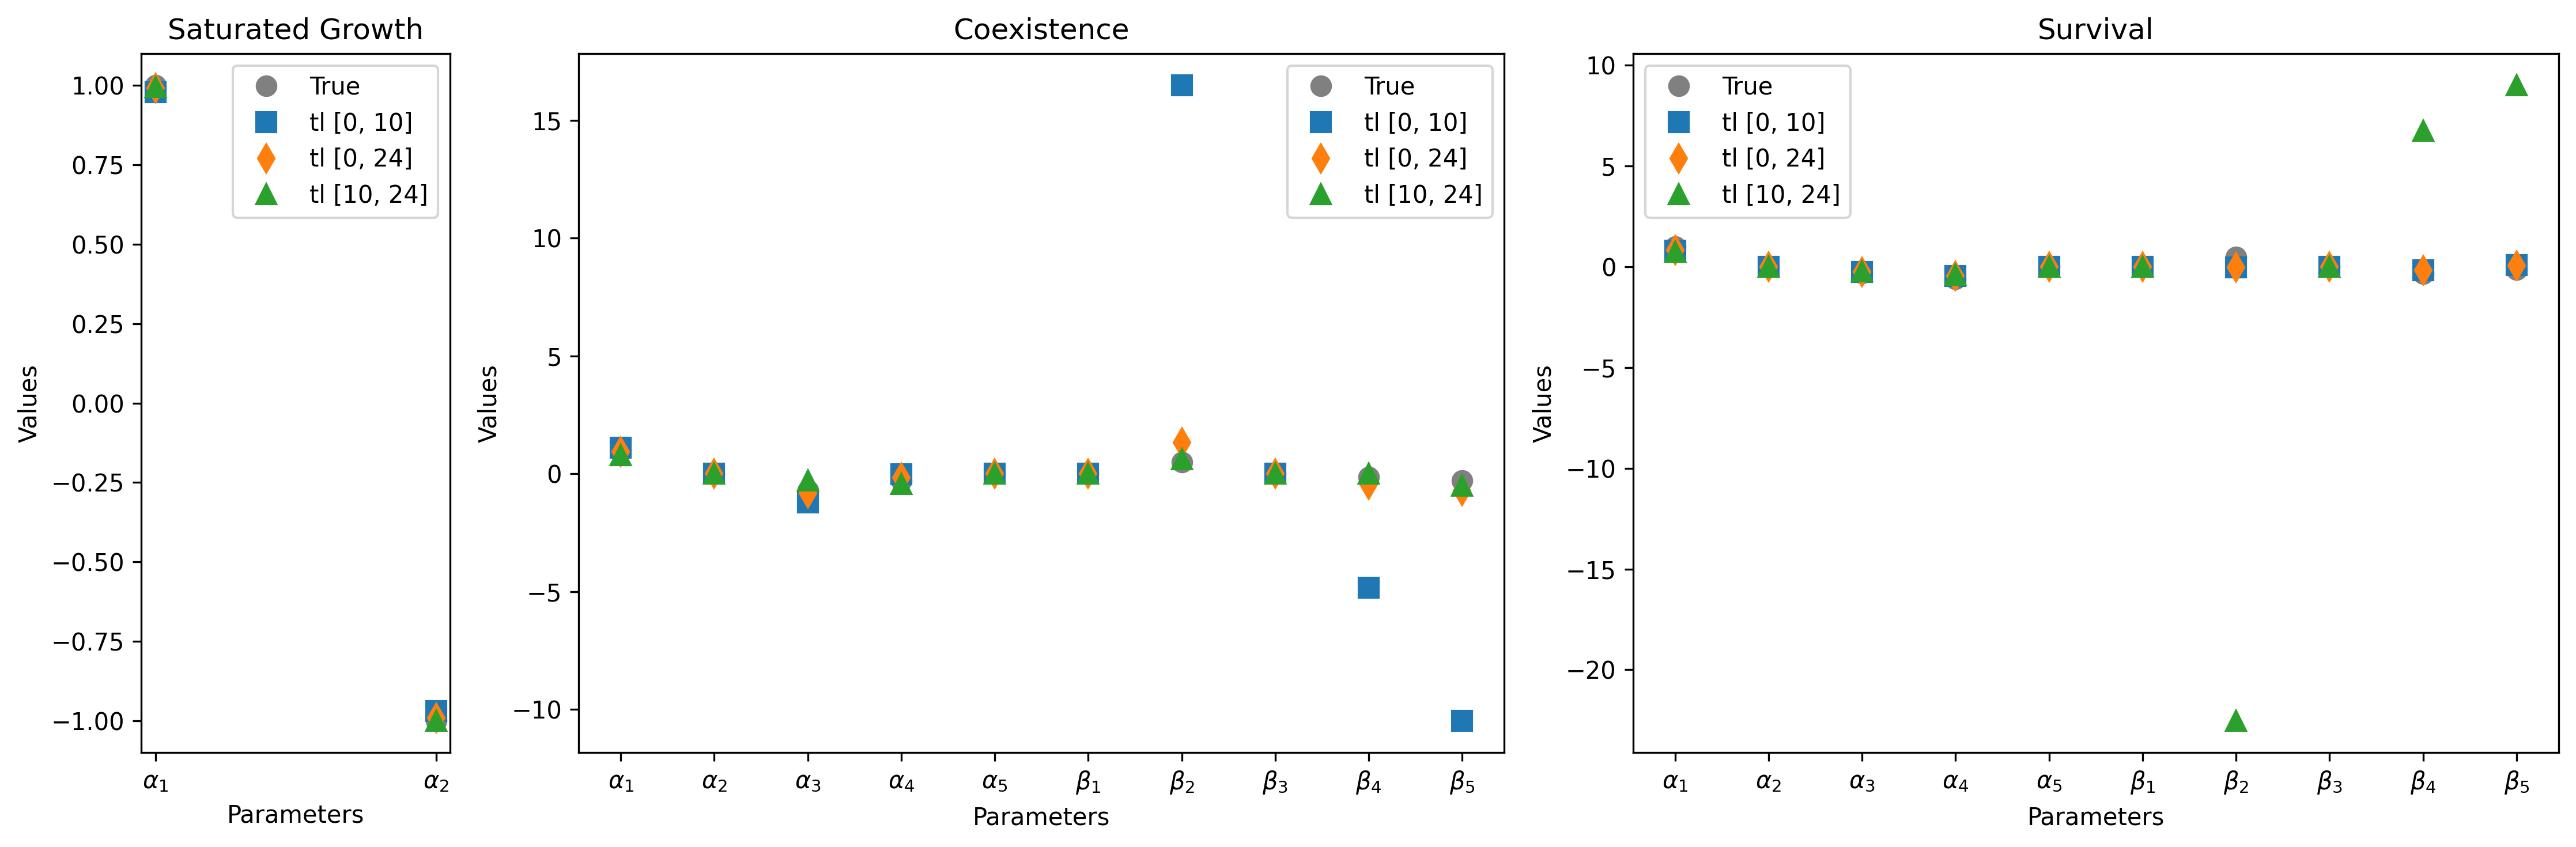

In [4]:
# True parameters for each model
coex_true_params = [1, 0, -0.7, -0.3, 0, 0, 0.5, 0, -0.5*0.3, -0.5*0.6]
surv_true_params = [1, 0, -0.3, -0.6, 0, 0, 0.5, 0, -0.5*0.7, -0.5*0.3]
sg_true_params = [1, -1]

# Define parameter name mappings for each model
coex_param_map = {
    'alpha_1': r'$\alpha_{1}$',
    'alpha_2': r'$\alpha_{2}$',
    'alpha_3': r'$\alpha_{3}$',
    'alpha_4': r'$\alpha_{4}$',
    'alpha_5': r'$\alpha_{5}$',
    'beta_1': r'$\beta_{1}$',
    'beta_2': r'$\beta_{2}$',
    'beta_3': r'$\beta_{3}$',
    'beta_4': r'$\beta_{4}$',
    'beta_5': r'$\beta_{5}$'
}
surv_param_map = coex_param_map.copy()  
sg_param_map = {
    'alpha_1': r'$\alpha_{1}$',
    'alpha_2': r'$\alpha_{2}$'
}

# Extract parameter names (keys) and their LaTeX representations (values)
coex_param_keys = list(coex_param_map.keys())
coex_param_values = list(coex_param_map.values())

surv_param_keys = list(surv_param_map.keys())
surv_param_values = list(surv_param_map.values())

sg_param_keys = list(sg_param_map.keys())
sg_param_values = list(sg_param_map.values())


def extract_params(param_dict, param_keys):
    return [param_dict.get(key, 0) for key in param_keys]

def plot_param_comparison(true_params, best_params_list, param_keys, param_values, title, ax):
    index = np.arange(len(param_keys))
    
    # Plot true parameters 
    ax.plot(index, true_params, marker='o', linestyle='None', label='True', color='gray', markersize=8)

    # Plot each best parameter set with different markers
    markers = ['s', 'd', '^']  # Square, triangle up, and diamond 
    for i, (param_dict, time_limit) in enumerate(best_params_list):
        params = extract_params(param_dict, param_keys)
        ax.plot(index, params, marker=markers[i % len(markers)], linestyle='None', label=f'tl {time_limit}', markersize=8)

    # Set labels and title
    ax.set_xlabel('Parameters')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(param_values)
    ax.legend()


# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300, gridspec_kw={'width_ratios': [1, 3, 3]})

# Extract best models for each tag
coex_models = best_models[best_models['Tag'] == 'Coex'][['Coefficients', 'Time_limit']].values
surv_models = best_models[best_models['Tag'] == 'Surv'][['Coefficients', 'Time_limit']].values
sg_models = best_models[best_models['Tag'] == 'SG'][['Coefficients', 'Time_limit']].values

# Plot comparisons
plot_param_comparison(sg_true_params, sg_models, sg_param_keys, sg_param_values, 'Saturated Growth', axs[0])
plot_param_comparison(coex_true_params, coex_models, coex_param_keys, coex_param_values, 'Coexistence', axs[1])
plot_param_comparison(surv_true_params, surv_models, surv_param_keys, surv_param_values, 'Survival', axs[2])


plt.tight_layout()
# save the plot
plt.savefig(f'PySINDy_model_params_comparison_{noise_level}.png')

In [5]:
best_models.rename(columns={'Tag': 'model_type'}, inplace=True)
best_models['model_type'] = best_models['model_type'].replace({'SG': 'sg', 'Coex': 'coexistence', 'Surv': 'survival'})
best_models.insert(0, 'tag', 'PySINDy')


In [6]:
best_models

,tag,model_type,Noise,Numx,Time_limit,Differentiation Type,MSE,Coefficients,Lambda
0,PySINDy,coexistence,0.005,100,"[0, 10]",SFD,0.005934,"{'alpha_1': 1.1, 'alpha_2': -0.0, 'alpha_3': -...",0.55
1,PySINDy,coexistence,0.005,100,"[0, 24]",SFD,0.002775,"{'alpha_1': 0.94, 'alpha_2': 0.0, 'alpha_3': -...",0.47
2,PySINDy,coexistence,0.005,100,"[10, 24]",FD,0.007231,"{'alpha_1': 0.78, 'alpha_2': 0.0, 'alpha_3': -...",0.39
3,PySINDy,sg,0.005,100,"[0, 10]",FD,0.000099,"{'alpha_1': 0.9781, 'alpha_2': -0.97}",0.03
4,PySINDy,sg,0.005,100,"[0, 24]",SFD,0.000014,"{'alpha_1': 0.9908, 'alpha_2': -0.99}",0.01
5,PySINDy,sg,0.005,100,"[10, 24]",FD,0.000020,"{'alpha_1': 0.9957, 'alpha_2': -1.0}",0.00
6,PySINDy,survival,0.005,100,"[0, 10]",FD,0.002193,"{'alpha_1': 0.8, 'alpha_2': -0.0, 'alpha_3': -...",0.40
7,PySINDy,survival,0.005,100,"[0, 24]",FD,0.000427,"{'alpha_1': 0.82, 'alpha_2': 0.0, 'alpha_3': -...",0.41
8,PySINDy,survival,0.005,100,"[10, 24]",SFD,0.088729,"{'alpha_1': 0.74, 'alpha_2': -0.0, 'alpha_3': ...",0.37


In [7]:
# save best_models in a csv file name PySINDy_combined_metrices_coefs.csv
best_models.to_csv(f'PySINDy_combined_metrices_coefs_{noise_level}.csv', index=False)